In [22]:
%reset -f

In [23]:
#import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score, precision_score, confusion_matrix, log_loss

# Load the new dataset for bank churn analysis
file_path = 'BankChurners.csv'
bank_data = pd.read_csv(file_path)

#Drop as instructed

bank_data = bank_data.drop(['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
                            'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'],axis=1)

# Get Column Names
column_names = bank_data.columns

### Skew Analysis

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# First, let's identify numerical columns and calculate skewness for each
numerical_cols = bank_data.select_dtypes(include=['int64', 'float64']).columns
skewness = bank_data[numerical_cols].skew()
# print(skewness)

# Now, let's find columns with skewness greater than 1 or less than -1 which indicates significant skewness
skewed_cols = skewness[(skewness > 1) | (skewness < -1)].index

# # Create distribution plots for skewed columns
# for col in skewed_cols:
#     plt.figure(figsize=(8, 4))
#     sns.histplot(bank_data[col], kde=True)
#     plt.title(f'Distribution of {col} (Skewness: {skewness[col]:.2f})')
#     plt.xlabel(col)
#     plt.ylabel('Frequency')
#     plt.show()


In [25]:
# Hyperparameters are set lower than usual as dataset is small and overfitting is a concern
# max_depth default of 6 is causing overfitting

max_depth = 3
learning_rate = 0.1
n_estimators = 100
random_state = 42
test_size = 0.2


### Quick Summary of Metrics
Accuracy measures the overall correctness of the model's predictions (the number of correct predictions divided by the total number of predictions). High accuracy on both training and test sets suggests that the model is performing well, but it's always important to consider this metric in the context of the problem's baseline accuracy and the balance of classes in your dataset.

F1 Score is the harmonic mean of precision and recall. It's particularly useful for evaluating models on imbalanced datasets. A high F1 score indicates that the model has a good balance between precision (the model's ability to label negative samples correctly) and recall (the model's ability to find all the positive samples).

ROC AUC (Area Under the Receiver Operating Characteristic Curve) measures the ability of the model to distinguish between the classes. A score closer to 1 indicates that the model has a good measure of separability; it's good at predicting true positives while minimizing false positives.

Log Loss evaluates the accuracy of the probabilistic predictions. It penalizes false classifications more when the model is more confident about its wrong predictions. Lower log loss values are better, indicating higher confidence in the correct predictions.

In [26]:
y = bank_data['Attrition_Flag'].apply(lambda x: 1 if "Attrited Customer" == x else 0)

bank_data_encoded = pd.DataFrame()

label_encoder = LabelEncoder()
for col_name in bank_data:
    if bank_data[col_name].dtype != 'int64' and bank_data[col_name].dtype != 'float64':
        bank_data[col_name+"_encoded"] = label_encoder.fit_transform(bank_data[col_name])
        bank_data_encoded[col_name+"_encoded"] = bank_data[col_name+"_encoded"]
    else:
        bank_data_encoded[col_name] = bank_data[col_name]

X = bank_data_encoded.drop(['Attrition_Flag_encoded','CLIENTNUM'],axis=1)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, shuffle=True)

xgb_classifier = xgb.XGBClassifier(random_state=random_state,eval_metric='logloss',use_label_encoder=False,
                                   max_depth=max_depth,learning_rate=learning_rate,n_estimators=n_estimators,verbosity=0,objective='binary:logistic')
xgb_classifier.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)

y_train_pred = xgb_classifier.predict(X_train)
y_test_pred = xgb_classifier.predict(X_test)



train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
logloss_result = xgb_classifier.evals_result()
train_logloss_last = logloss_result['validation_0']['logloss'][-1]
test_logloss_last = logloss_result['validation_1']['logloss'][-1]
# Calculate Lift Score

print(f"""Data Pre-Normalization:
      Train Accuracy: {train_accuracy*100:.2f}%
      Test Accuracy: {test_accuracy*100:.2f}%
      F1 Score: {f1*100:.2f}%
        Recall: {recall*100:.2f}%
        Precision: {precision*100:.2f}%
      ROC AUC: {roc_auc*100:.2f}%
      Train Log Loss: {train_logloss_last:.4f}
      Test Log Loss: {test_logloss_last:.4f}""")


Data Pre-Normalization:
      Train Accuracy: 97.56%
      Test Accuracy: 96.74%
      F1 Score: 89.35%
        Recall: 84.71%
        Precision: 94.54%
      ROC AUC: 91.88%
      Train Log Loss: 0.0837
      Test Log Loss: 0.1031


In [28]:
from sklearn.metrics import precision_recall_fscore_support

# Assuming you have already made predictions using your classifier
y_pred = xgb_classifier.predict(X_test)

# Calculate precision and recall for both classes
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred)

# Results
print(f"Precision for class 0: {precision[0]*100:.2f}")
print(f"Recall for class 0: {recall[0]*100:.2f}")
print(f"Precision for class 1: {precision[1]*100:.2f}")
print(f"Recall for class 1: {recall[1]*100:.2f}")

Precision for class 0: 97.11
Recall for class 0: 99.06
Precision for class 1: 94.54
Recall for class 1: 84.71


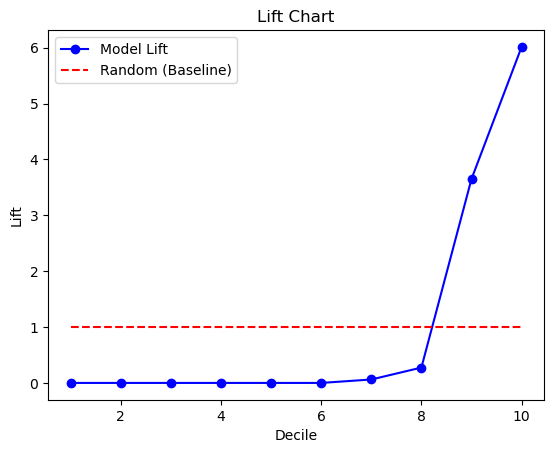

In [29]:


# Example predictions
y_test_pred_proba = xgb_classifier.predict_proba(X_test)[:, 1]

# Creating a DataFrame
data = pd.DataFrame({'true': y_test, 'proba': y_test_pred_proba})
data['decile'] = pd.qcut(data['proba'], 10, labels=False)
data.sort_values('proba', ascending=False, inplace=True)
data['cumulative_response'] = data.groupby('decile')['true'].transform(pd.Series.cumsum)
data['cumulative_count'] = data.groupby('decile').cumcount() + 1
data['baseline'] = data['true'].sum() / len(data)
data['lift'] = data['cumulative_response'] / (data['cumulative_count'] * data['baseline'])

# Calculate lift at each decile
lift_at_decile = data.groupby('decile')['lift'].last()

# Plotting
plt.plot(lift_at_decile.index + 1, lift_at_decile, marker='o', linestyle='-', color='b', label='Model Lift')
plt.plot(lift_at_decile.index + 1, np.ones_like(lift_at_decile), color='r', linestyle='--', label='Random (Baseline)')
plt.xlabel('Decile')
plt.ylabel('Lift')
plt.title('Lift Chart')
plt.legend()
plt.show()




### Normalized Data

In [30]:
from sklearn.preprocessing import PowerTransformer
from scipy.stats import skew, boxcox
# Apply PowerTransformer to the skewed columns

pt = PowerTransformer()
X_normalized = X.copy()

skewed_cols = skewness[(skewness > 1) | (skewness < -1)].index
# print(skewed_cols)
X_normalized[skewed_cols] = pt.fit_transform(X_normalized[skewed_cols])
X_normalized_train, X_normalized_test, y_train, y_test = train_test_split(X_normalized, y, test_size=test_size, random_state=random_state,shuffle=True)

# for i in skewed_cols:
#     transformed_skew = skew(X_normalized[i])
#     plt.figure(figsize=(8, 4))
#     sns.histplot(X_normalized[i], kde=True)
#     plt.title(f'Distribution of {i} (Skewness: {skew(X_normalized[i]):.2f})')
#     plt.xlabel(i)
#     plt.ylabel('Frequency')
#     plt.show()

xgb_classifier = xgb.XGBClassifier(random_state=random_state,eval_metric='logloss',use_label_encoder=False,
                                   max_depth=max_depth,learning_rate=learning_rate,n_estimators=n_estimators,verbosity=0,objective='binary:logistic')
xgb_classifier.fit(X_normalized_train, y_train, eval_set=[(X_normalized_train, y_train), (X_normalized_test, y_test)], verbose=False)

y_train_pred = xgb_classifier.predict(X_normalized_train)
y_test_pred = xgb_classifier.predict(X_normalized_test)


train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
logloss_result = xgb_classifier.evals_result()
train_logloss_last = logloss_result['validation_0']['logloss'][-1]
test_logloss_last = logloss_result['validation_1']['logloss'][-1]

print(f"""Data Post-Normalization:
      Train Accuracy: {train_accuracy*100:.2f}%
      Test Accuracy: {test_accuracy*100:.2f}%
      F1 Score: {f1*100:.2f}%
            Recall: {recall*100:.2f}%
            Precision: {precision*100:.2f}%
      ROC AUC: {roc_auc*100:.2f}%
      Train Log Loss: {train_logloss_last:.4f}
      Test Log Loss: {test_logloss_last:.4f}""")


Data Post-Normalization:
      Train Accuracy: 97.56%
      Test Accuracy: 96.74%
      F1 Score: 89.35%
            Recall: 84.71%
            Precision: 94.54%
      ROC AUC: 91.88%
      Train Log Loss: 0.0837
      Test Log Loss: 0.1031


In [31]:
import pandas as pd
y_test_pred_proba = xgb_classifier.predict_proba(X_normalized_test)[:, 1]

data = pd.DataFrame({'actual': y_test, 'predicted':y_test_pred, 'predicted_proba' :y_test_pred_proba})
data['quintiles'] = pd.qcut(data['predicted_proba'], 5, labels=False)
response_rate = data.groupby('quintiles')['actual'].mean()
overall_response_rate = data['actual'].mean()
# Calculate lift score
lift_score = response_rate / overall_response_rate
lift_score

quintiles
0    0.000000
1    0.000000
2    0.000000
3    0.168279
4    4.834190
Name: actual, dtype: float64

#### Notes:
This shows that there is no real benefit to normalization of the data due to no observable differences.

### Feature Trimming

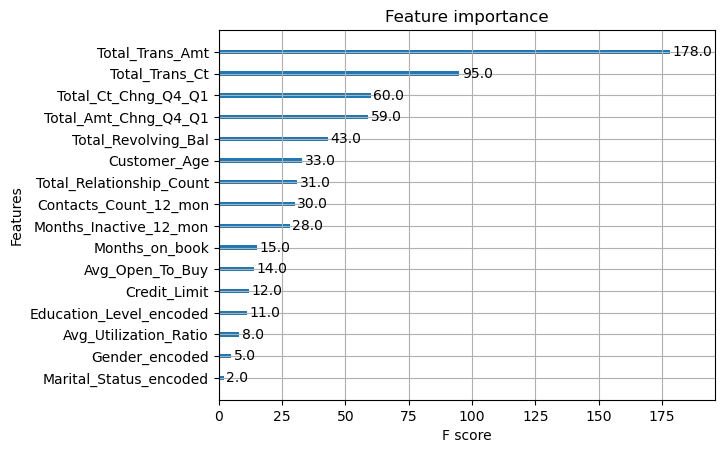

Index(['Customer_Age', 'Gender_encoded', 'Dependent_count',
       'Education_Level_encoded', 'Marital_Status_encoded',
       'Income_Category_encoded', 'Card_Category_encoded', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'],
      dtype='object')


In [32]:
# Feature selection using XGBoost
from xgboost import plot_importance
import matplotlib.pyplot as plt

# Train the model

xgb_classifier = xgb.XGBClassifier(random_state=random_state,eval_metric='logloss',use_label_encoder=False,
                                   max_depth=max_depth,learning_rate=learning_rate,n_estimators=n_estimators,verbosity=0,objective='binary:logistic')
xgb_classifier.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)

plot_importance(xgb_classifier, importance_type='weight')
plt.show()

feature_importance = xgb_classifier.feature_importances_

# Sort by importance

sorted_importance = [x for _, x in sorted(zip(feature_importance, X_train.columns), reverse=True)]
print(X_train.columns)
# Print the feature importance

In [33]:


def evaluate_model_with_features(features):
    # Train and evaluate the model with the specified features
    X_train_subset = X_train[features]
    X_test_subset = X_test[features]
    
    xgb_classifier = xgb.XGBClassifier(random_state=random_state, eval_metric='logloss', use_label_encoder=False,
                                       max_depth=max_depth,learning_rate=learning_rate,n_estimators=n_estimators,verbosity=0,objective='binary:logistic')
    xgb_classifier.fit(X_train_subset, y_train, eval_set=[(X_train_subset, y_train), (X_test_subset, y_test)], verbose=False)
    
    # Making predictions
    y_train_pred = xgb_classifier.predict(X_train_subset)
    y_test_pred = xgb_classifier.predict(X_test_subset)
    y_train_pred_proba = xgb_classifier.predict_proba(X_train_subset)[:,1]
    y_test_pred_proba = xgb_classifier.predict_proba(X_test_subset)[:,1]
    
    # Calculating metrics
    metrics = {
        'Train Accuracy': accuracy_score(y_train, y_train_pred),
        'Test Accuracy': accuracy_score(y_test, y_test_pred),
        'F1 Score': f1_score(y_test, y_test_pred),
        'Precision': precision_score(y_test, y_test_pred),
        'Recall': recall_score(y_test, y_test_pred),
        'ROC AUC': roc_auc_score(y_test, y_test_pred),
        'Train Log Loss': log_loss(y_train, y_train_pred_proba),
        'Test Log Loss': log_loss(y_test, y_test_pred_proba)
        # Get inve
    }
    
    return metrics

# Iterating over features and collecting metrics
all_metrics = []
for i in range(1, len(sorted_importance) + 1):
    features = sorted_importance[:i]
    metrics = evaluate_model_with_features(features)
    all_metrics.append(metrics)


In [34]:
# Convert the list of dictionaries to a DataFrame
import pandas as pd
metrics_df = pd.DataFrame(all_metrics)
metrics_df.index = range(1, len(sorted_importance) + 1) 
metrics_df.index.name = 'Number of Features'
metrics_df

,Train Accuracy,Test Accuracy,F1 Score,Precision,Recall,ROC AUC,Train Log Loss,Test Log Loss
Number of Features,,,,,,,,
1,0.848661,0.849457,0.349680,0.577465,0.250765,0.607725,0.320650,0.354791
2,0.899395,0.891412,0.616725,0.716599,0.541284,0.750042,0.247480,0.281913
3,0.916677,0.910661,0.685217,0.794355,0.602446,0.786214,0.210655,0.237290
4,0.928280,0.916091,0.702797,0.820408,0.614679,0.794391,0.187659,0.221021
5,0.960252,0.949654,0.832237,0.900356,0.773700,0.878610,0.108085,0.123855
6,0.960992,0.950642,0.835526,0.903915,0.776758,0.880433,0.104767,0.121835
7,0.962474,0.953603,0.845902,0.911661,0.788991,0.887138,0.100967,0.120155
8,0.970497,0.960513,0.871383,0.918644,0.828746,0.907310,0.090515,0.109986
9,0.975065,0.965449,0.886364,0.944637,0.834862,0.912723,0.085160,0.105577


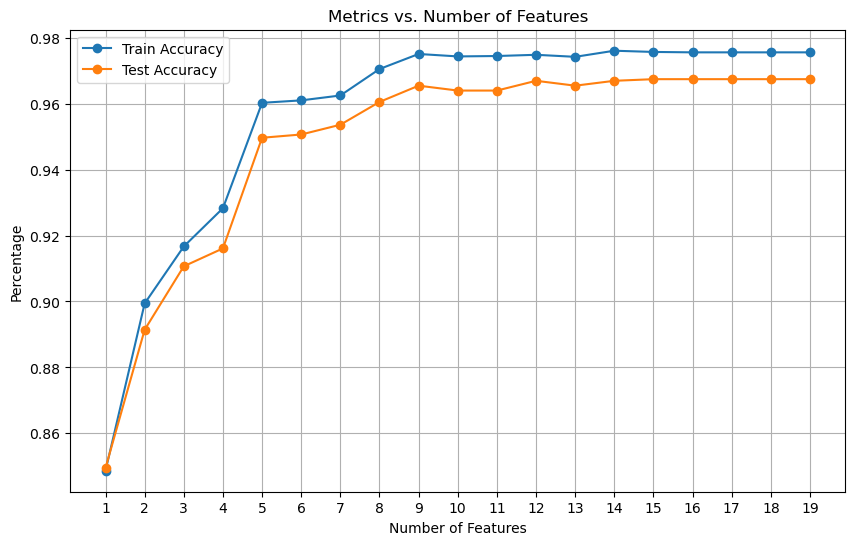

In [35]:
# Example plot for Test Accuracy
plt.figure(figsize=(10, 6))
train_accurracies = [m['Train Accuracy'] for m in all_metrics]
test_accuracies = [m['Test Accuracy'] for m in all_metrics]
plt.plot(range(1, len(sorted_importance) + 1), train_accurracies, marker='o', label='Train Accuracy')
plt.plot(range(1, len(sorted_importance) + 1), test_accuracies, marker='o', label='Test Accuracy')
plt.xticks(range(1, len(sorted_importance) + 1))
plt.grid(True)
plt.xlabel('Number of Features')
plt.ylabel('Percentage')
plt.title('Metrics vs. Number of Features')
plt.legend()
plt.show()


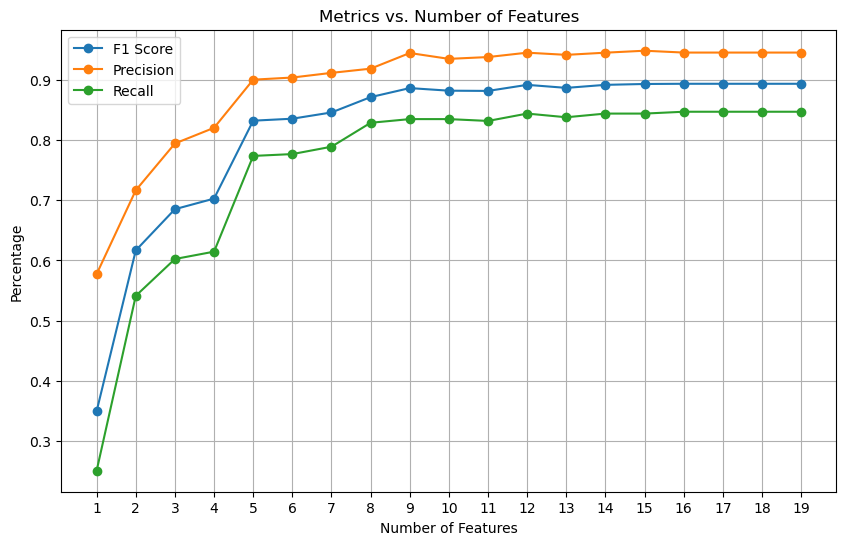

In [36]:
# Plot F1, Precision, Recall
plt.figure(figsize=(10, 6))
f1_scores = [m['F1 Score'] for m in all_metrics]
precision_scores = [m['Precision'] for m in all_metrics]
recall_scores = [m['Recall'] for m in all_metrics]
plt.plot(range(1, len(sorted_importance) + 1), f1_scores, marker='o', label='F1 Score')
plt.plot(range(1, len(sorted_importance) + 1), precision_scores, marker='o', label='Precision')
plt.plot(range(1, len(sorted_importance) + 1), recall_scores, marker='o', label='Recall')
plt.xticks(range(1, len(sorted_importance) + 1))
plt.grid(True)
plt.xlabel('Number of Features')
plt.ylabel('Percentage')
plt.title('Metrics vs. Number of Features')
plt.legend()
plt.show()



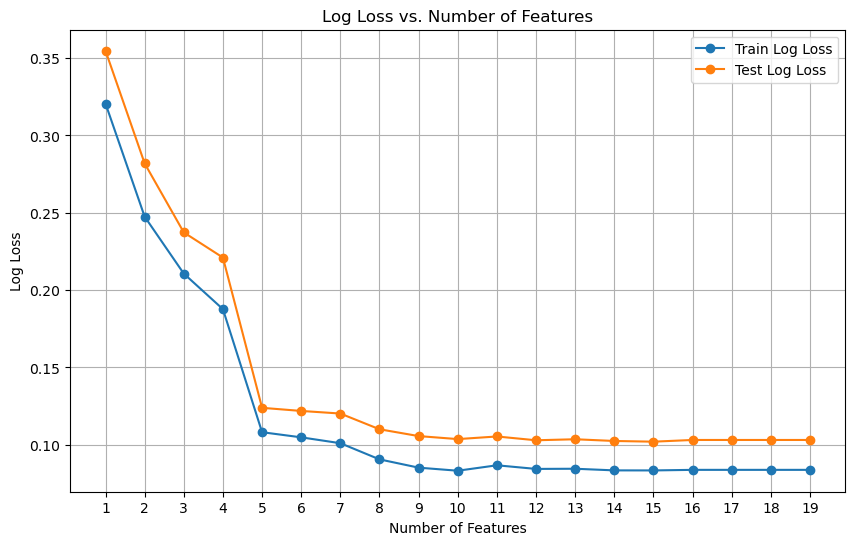

In [37]:
# Plot for Inverse Log Loss
plt.figure(figsize=(10, 6))
train_log_losses = [m['Train Log Loss'] for m in all_metrics]
test_log_losses = [m['Test Log Loss'] for m in all_metrics]
plt.plot(range(1, len(sorted_importance) + 1), train_log_losses, marker='o', label='Train Log Loss')
plt.plot(range(1, len(sorted_importance) + 1), test_log_losses, marker='o', label='Test Log Loss')
plt.xticks(range(1, len(sorted_importance) + 1))
plt.grid(True)
plt.xlabel('Number of Features')
plt.ylabel('Log Loss')
plt.title('Log Loss vs. Number of Features')
plt.legend()
plt.show()



#### Notes:
Feature selection seems to suggest having 5-6 features is the most efficient, any other than that and returns will start diminishing,

Model tends to overfit over 15

## Trim down to only top 5 features and retrain

In [38]:

# Trim data down to top 5 features
top_features = sorted_importance[:5]
X_trim = X.copy()
X_trim = X_trim[top_features]
X_trim_train, X_trim_test, y_train, y_test = train_test_split(X_trim, y, test_size=test_size, random_state=random_state, shuffle=True)
xgb_classifier = xgb.XGBClassifier(random_state=random_state,eval_metric='logloss',use_label_encoder=False,
                                   max_depth=max_depth,learning_rate=learning_rate,n_estimators=n_estimators,verbosity=0,objective='binary:logistic')
xgb_classifier.fit(X_trim_train, y_train, eval_set=[(X_trim_train, y_train), (X_trim_test, y_test)], verbose=False)

y_train_pred = xgb_classifier.predict(X_trim_train)
y_test_pred = xgb_classifier.predict(X_trim_test)

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_pred)
logloss_result = xgb_classifier.evals_result()
train_logloss_last = logloss_result['validation_0']['logloss'][-1]
test_logloss_last = logloss_result['validation_1']['logloss'][-1]

print(f"""Data Pre-Normalization - Top 5 Features:
      Train Accuracy: {train_accuracy*100:.2f}%
      Test Accuracy: {test_accuracy*100:.2f}%
      F1 Score: {f1*100:.2f}%
      Precision: {precision*100:.2f}%
      Recall: {recall*100:.2f}%
      ROC AUC: {roc_auc*100:.2f}%
      Train Log Loss: {train_logloss_last:.4f}
      Test Log Loss: {test_logloss_last:.4f}""")


Data Pre-Normalization - Top 5 Features:
      Train Accuracy: 96.03%
      Test Accuracy: 94.97%
      F1 Score: 83.22%
      Precision: 90.04%
      Recall: 77.37%
      ROC AUC: 87.86%
      Train Log Loss: 0.1081
      Test Log Loss: 0.1239


Comparison shows no improvement compared to using the full dataset

#### HyperParameter Tuning

In [39]:
# Reset to original setting

# max_depth = 4 overfits 99% of the time
X_train, X_test, y_train, y_test = train_test_split(X_trim, y, test_size=test_size, random_state=random_state, shuffle=True)
# loop for different learning_rate and n_estimators

learning_rates = []
for i in np.arange(0.1,0.6,0.1):
    learning_rates.append(i)
    
n_estimators = []
for i in np.arange(100,600,100):
    n_estimators.append(i)

results = {}
for max_d in [2,3]:
    for lr in learning_rates:
        for n_est in n_estimators:
            xgb_classifier = xgb.XGBClassifier(random_state=random_state,eval_metric='logloss',use_label_encoder=False,
                                            max_depth=max_d,learning_rate=lr,n_estimators=n_est,verbosity=0,objective='binary:logistic')
            xgb_classifier.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)
            y_train_pred = xgb_classifier.predict(X_train)
            y_test_pred = xgb_classifier.predict(X_test)
            y_test_pred_proba = xgb_classifier.predict_proba(X_test)[:, 1]
            train_accuracy = accuracy_score(y_train, y_train_pred)
            test_accuracy = accuracy_score(y_test, y_test_pred)
            f1 = f1_score(y_test, y_test_pred)
            roc_auc = roc_auc_score(y_test, y_test_pred)
            precision = precision_score(y_test, y_test_pred)
            recall = recall_score(y_test, y_test_pred)
            logloss_result = xgb_classifier.evals_result()
            train_logloss_last = logloss_result['validation_0']['logloss'][-1]
            test_logloss_last = logloss_result['validation_1']['logloss'][-1]
            results[(max_d,lr, n_est)] = {
                'Train Accuracy': train_accuracy,
                'Test Accuracy': test_accuracy,
                'F1 Score': f1,
                'Precision': precision,
                'Recall': recall,
                'ROC AUC': roc_auc,
                'Train Log Loss': train_logloss_last,
                'Test Log Loss': test_logloss_last
            }
results_df = pd.DataFrame(results).T
results_df.index.names = ['Max Depth','Learning Rate', 'N Estimators']
results_df['Accuracy_Diff'] = results_df['Train Accuracy'] - results_df['Test Accuracy']
results_df['Log_Loss_Diff'] = results_df['Train Log Loss'] - results_df['Test Log Loss']
results_df



Train Accuracy  Test Accuracy  F1 Score  \
Max Depth Learning Rate N Estimators                                            
2         0.1           100                 0.951117       0.947187  0.820168   
                        200                 0.957783       0.951629  0.840391   
                        300                 0.960499       0.952616  0.845161   
                        400                 0.961610       0.954590  0.851613   
                        500                 0.962844       0.955084  0.853462   
          0.2           100                 0.958647       0.952616  0.843137   
                        200                 0.962350       0.955084  0.852989   
                        300                 0.964572       0.956565  0.859873   
                        400                 0.966918       0.955577  0.856688   
                        500                 0.969510       0.955577  0.856688   
          0.3           100                 0.960128       0.956071  0.855754   
                        200                 0.964079       0.956565  0.858974   
                        300                 0.968399       0.954097  0.850722   
                        400                 0.970497       0.954590  0.853503   
                        500                 0.971979       0.955084  0.854864   
          0.4           100                 0.960869       0.956565  0.858065   
                        200                 0.968029       0.956071  0.857600   
                        300                 0.970497       0.951629  0.844444   
                        400                 0.974448       0.950148  0.840442   
                        500                 0.975805       0.951135  0.844094   
          0.5           100                 0.963708       0.953110  0.846029   
                        200                 0.969016       0.953110  0.849445   
                        300                 0.972843       0.950642  0.841772   
                        400                 0.974941       0.950148  0.839428   
                        500                 0.978521       0.949161  0.836767   
3         0.1           100                 0.960252       0.949654  0.832237   
                        200                 0.963585       0.950642  0.837662   
                        300                 0.966671       0.951135  0.840065   
                        400                 0.969880       0.953110  0.846527   
                        500                 0.972349       0.953603  0.848875   
          0.2           100                 0.964202       0.952616  0.844156   
                        200                 0.970621       0.955084  0.853933   
                        300                 0.975682       0.955084  0.854400   
                        400                 0.979385       0.952122  0.845295   
                        500                 0.982595       0.950148  0.838400   
          0.3           100                 0.967905       0.952616  0.845659   
                        200                 0.976176       0.951135  0.842105   
                        300                 0.982471       0.949654  0.838608   
                        400                 0.986421       0.950642  0.841772   
                        500                 0.990495       0.950148  0.840945   
          0.4           100                 0.970497       0.948174  0.830918   
                        200                 0.980496       0.950148  0.839428   
                        300                 0.986915       0.951629  0.844444   
                        400                 0.991976       0.950642  0.841772   
                        500                 0.995186       0.948174  0.834123   
          0.5           100                 0.973830       0.950642  0.840256   
                        200                 0.984446       0.954590  0.854430   
                        300                 0.991729       0.949654  

In [40]:
results_df = results_df.sort_values(by =['Recall','Accuracy_Diff','Test Accuracy'],ascending=[True,True,False])
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#Filter for best results
results_df

Train Accuracy  Test Accuracy  F1 Score  \
Max Depth Learning Rate N Estimators                                            
2         0.1           100                 0.951117       0.947187  0.820168   
3         0.1           100                 0.960252       0.949654  0.832237   
2         0.2           100                 0.958647       0.952616  0.843137   
          0.1           200                 0.957783       0.951629  0.840391   
3         0.1           200                 0.963585       0.950642  0.837662   
          0.4           100                 0.970497       0.948174  0.830918   
          0.2           100                 0.964202       0.952616  0.844156   
          0.1           300                 0.966671       0.951135  0.840065   
2         0.5           100                 0.963708       0.953110  0.846029   
          0.1           300                 0.960499       0.952616  0.845161   
3         0.1           400                 0.969880       0.953110  0.846527   
          0.2           500                 0.982595       0.950148  0.838400   
          0.3           100                 0.967905       0.952616  0.845659   
          0.5           100                 0.973830       0.950642  0.840256   
2         0.3           100                 0.960128       0.956071  0.855754   
          0.1           400                 0.961610       0.954590  0.851613   
          0.2           200                 0.962350       0.955084  0.852989   
3         0.1           500                 0.972349       0.953603  0.848875   
2         0.5           400                 0.974941       0.950148  0.839428   
3         0.3           200                 0.976176       0.951135  0.842105   
2         0.5           500                 0.978521       0.949161  0.836767   
3         0.4           200                 0.980496       0.950148  0.839428   
                        500                 0.995186       0.948174  0.834123   
2         0.1           500                 0.962844       0.955084  0.853462   
          0.3           300                 0.968399       0.954097  0.850722   
3         0.2           400                 0.979385       0.952122  0.845295   
          0.3           300                 0.982471       0.949654  0.838608   
2         0.4           100                 0.960869       0.956565  0.858065   
3         0.2           200                 0.970621       0.955084  0.853933   
2         0.4           300                 0.970497       0.951629  0.844444   
          0.5           300                 0.972843       0.950642  0.841772   
          0.4           400                 0.974448       0.950148  0.840442   
3         0.4           300                 0.986915       0.951629  0.844444   
          0.3           400                 0.986421       0.950642  0.841772   
          0.4           400                 0.991976       0.950642  0.841772   
          0.2           300                 0.975682       0.955084  0.854400   
          0.3           500                 0.990495       0.950148  0.840945   
2         0.3           200                 0.964079       0.956565  0.858974   
          0.4           200                 0.968029       0.956071  0.857600   
          0.5           200                 0.969016       0.953110  0.849445   
          0.3           400                 0.970497       0.954590  0.853503   
                        500                 0.971979       0.955084  0.854864   
          0.4           500                 0.975805       0.951135  0.844094   
3         0.5           300                 0.991729       0.949654  0.840125   
                        400                 0.995433       0.950642  0.842767   
2         0.2           400                 0.966918       0.955577  0.856688   
                        500                 0.969510       0.955577  0.856688   
                        300                 0.964572       0.956565  

#### Notes:
Seems like F1 Score will not improve beyond 91%, and the best HyperParamers avaliable is set Max_Depth to 3, Learning_Rate to 0.3, and N estimatiors to 200

Recall needs to be priortized as there is no drawback in making a false positive.

In [41]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
# Perform Grid Search to find best Recall

# Define the parameter grid
param_grid = {
    'max_depth': [2, 3, 4, 5],
    'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
    'n_estimators': [100, 200, 300, 400, 500]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=XGBClassifier(random_state=random_state,eval_metric='logloss',use_label_encoder=False,objective='binary:logistic'),
    param_grid=param_grid,
    scoring='recall',
    cv=5,
    n_jobs=-1
)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the results
results = grid_search.cv_results_
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='rank_test_score')
results_df = results_df[['param_max_depth', 'param_learning_rate', 'param_n_estimators', 'mean_test_score', 'rank_test_score']]
results_df


,param_max_depth,param_learning_rate,param_n_estimators,mean_test_score,rank_test_score
8,3,0.1,400,0.829231,1
42,2,0.3,300,0.828462,2
63,2,0.4,400,0.828462,2
44,2,0.3,500,0.828462,4
41,2,0.3,200,0.827692,5
62,2,0.4,300,0.827692,5
16,5,0.1,200,0.826923,7
4,2,0.1,500,0.826154,8
35,5,0.2,100,0.826154,8
45,3,0.3,100,0.826154,10
